In [315]:
import numpy as np
import pandas as pd
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive
from models.kinematic.ICR_based import *
from models.kinematic.Perturbed_unicycle import *
from models.kinematic.enhanced_kinematic import *

from util.transform_algebra import *

from sklearn import linear_model

3.10.6 (main, Nov 14 2022, 16:10:14) [GCC 11.3.0]


In [316]:
#import ing dataset

# marmotte
# grand salon
# full_dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl')
# full_dataset_length = len(full_dataset)
# dataset_snow = full_dataset[:int(full_dataset_length/2)]
# dataset_test = full_dataset[int(full_dataset_length/2):]
# dataset_test.index = np.arange(0, len(dataset_test))
# grand axe
# dataset_snow = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl')
# dataset_test = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_b/slip_dataset_all.pkl')

# husky
#grand salon
full_dataset = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/husky/grand_salon_a_inflated/slip_dataset_all.pkl')
full_dataset_length = len(full_dataset)
dataset_snow = full_dataset[:int(full_dataset_length/2)]
dataset_test = full_dataset[int(full_dataset_length/2):]
dataset_test.index = np.arange(0, len(dataset_test))



# '/home/dominic/repos/norlab_WMRD/data/marmotte/grand_salon_20_01_b/slip_dataset_all.pkl' # grand salon
# '/home/dominic/repos/norlab_WMRD/data/marmotte/ga_hard_snow_25_01_a/slip_dataset_all.pkl' # snow

print(dataset_snow)
print(dataset_test)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0           0.0         0.0         0.0            0.0             0.0   
1           0.0         0.0         0.0            0.0             0.0   
2           0.0         0.0         0.0            0.0             0.0   
3           0.0         0.0         0.0            0.0             0.0   
4           0.0         0.0         0.0            0.0             0.0   
..          ...         ...         ...            ...             ...   
295         0.0         0.0         0.0            0.0             0.0   
296         0.0         0.0         0.0            0.0             0.0   
297         0.0         0.0         0.0            0.0             0.0   
298         0.0         0.0         0.0            0.0             0.0   
299         0.0         0.0         0.0            0.0             0.0   

     init_icp_yaw  calib_step  cmd_left_0  cmd_right_0  cmd_left_1  ...  \
0             0.0         0.0   -0.0

In [317]:
# extract body_vel_distruptions arrays (output arrays)

str_body_vel_disturption_x_list = []
str_body_vel_disturption_y_list = []
str_body_vel_disturption_yaw_list = []
for i in range(0, 40):
    str_body_vel_disturption_x_i = 'body_vel_disturption_x_' + str(i)
    str_body_vel_disturption_y_i = 'body_vel_disturption_y_' + str(i)
    str_body_vel_disturption_yaw_i = 'body_vel_disturption_yaw_' + str(i)
    str_body_vel_disturption_x_list.append(str_body_vel_disturption_x_i)
    str_body_vel_disturption_y_list.append(str_body_vel_disturption_y_i)
    str_body_vel_disturption_yaw_list.append(str_body_vel_disturption_yaw_i)
    
body_vel_disturption_x_array = dataset_snow[str_body_vel_disturption_x_list].to_numpy()
body_vel_disturption_y_array = dataset_snow[str_body_vel_disturption_y_list].to_numpy()
body_vel_disturption_yaw_array = dataset_snow[str_body_vel_disturption_yaw_list].to_numpy()

y_train_longitudinal_slip = body_vel_disturption_x_array.flatten()
y_train_lateral_slip = body_vel_disturption_y_array.flatten()
y_train_angular_slip = body_vel_disturption_yaw_array.flatten()

print(np.max(y_train_longitudinal_slip))

0.4431990744863749


In [318]:
# extract icp vels

str_icp_vel_x_list = []
str_icp_vel_y_list = []
str_icp_vel_yaw_list = []
for i in range(0, 40):
    str_icp_vel_x_i = 'icp_vel_x_' + str(i)
    str_icp_vel_y_i = 'icp_vel_y_' + str(i)
    str_icp_vel_yaw_i = 'icp_vel_yaw_' + str(i)
    str_icp_vel_x_list.append(str_icp_vel_x_i)
    str_icp_vel_y_list.append(str_icp_vel_y_i)
    str_icp_vel_yaw_list.append(str_icp_vel_yaw_i)
    
icp_vel_x_array = dataset_snow[str_icp_vel_x_list].to_numpy()
icp_vel_y_array = dataset_snow[str_icp_vel_y_list].to_numpy()
icp_vel_yaw_array = dataset_snow[str_icp_vel_yaw_list].to_numpy()

In [319]:
# compute velocity deltas (BLR output ararys)

dt = 0.05

icp_vel_diff_x_array = np.zeros((icp_vel_x_array.shape[0], icp_vel_x_array.shape[1]))
icp_vel_diff_y_array = np.zeros((icp_vel_x_array.shape[0], icp_vel_x_array.shape[1]))
icp_vel_diff_yaw_array = np.zeros((icp_vel_x_array.shape[0], icp_vel_x_array.shape[1]))

for i in range(0, icp_vel_x_array.shape[0]):
    for j in range(0, icp_vel_x_array.shape[1]-1):
        icp_vel_diff_x_array[i,j] = (icp_vel_x_array[i, j+1] - icp_vel_x_array[i, j]) / dt
        icp_vel_diff_y_array[i,j] = (icp_vel_y_array[i, j+1] - icp_vel_y_array[i, j]) / dt
        icp_vel_diff_yaw_array[i,j] = (icp_vel_yaw_array[i, j+1] - icp_vel_yaw_array[i, j]) / dt

In [320]:
# extract cmd_body_vel arrays (input arrays)

idd_body_vel_x_str_list = []
idd_body_vel_y_str_list = []
idd_body_vel_yaw_str_list = []
for i in range(0, 40):
    str_idd_vel_x_i = 'idd_vel_x_' + str(i)
    str_idd_vel_y_i = 'idd_vel_y_' + str(i)
    str_idd_vel_yaw_i = 'idd_vel_yaw_' + str(i)
    idd_body_vel_x_str_list.append(str_idd_vel_x_i)
    idd_body_vel_y_str_list.append(str_idd_vel_y_i)
    idd_body_vel_yaw_str_list.append(str_idd_vel_yaw_i)
idd_body_vel_x_array = dataset_snow[idd_body_vel_x_str_list].to_numpy()
idd_body_vel_y_array = dataset_snow[idd_body_vel_y_str_list].to_numpy()
idd_body_vel_yaw_array = dataset_snow[idd_body_vel_yaw_str_list].to_numpy()

x_train = np.column_stack((idd_body_vel_x_array.flatten(), idd_body_vel_yaw_array.flatten()))

print(x_train.shape)

(12000, 2)


(-1.5, 1.5)

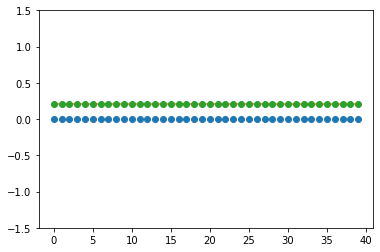

In [321]:
test_window = 175

plt.plot(body_vel_disturption_x_array[test_window, :], 'o')
plt.plot(idd_body_vel_x_array[test_window, :])
plt.plot(icp_vel_x_array[test_window, :], 'o')
# plt.plot(icp_vel_diff_x_array[test_window, :], 'o')

# plt.plot(x_train[:, 0])
# plt.plot(icp_interpolated_x_array[test_window, :], 'o', alpha = 0.5)

plt.ylim(-1.5, 1.5)

# print(x_train)

(-1.0, 1.0)

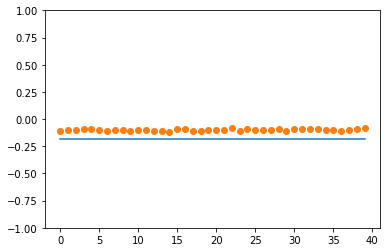

In [322]:
# plt.plot(body_vel_disturption_yaw_array[test_window, :], 'o')
plt.plot(idd_body_vel_yaw_array[test_window, :])
# plt.plot(y_train_longitudinal_slip)
plt.plot(icp_vel_yaw_array[test_window, :], 'o')
# plt.plot(icp_interpolated_yaw_array[test_window, :], 'o')

plt.ylim(-1, 1)

In [323]:
# compute mean body vel disturbance for each steady-state window
n_windows = len(dataset_snow)

steady_state_mask = dataset_snow['steady_state_mask'].to_numpy() == True

steady_state_idd_body_vel_x = idd_body_vel_x_array[steady_state_mask]
steady_state_idd_body_vel_y = idd_body_vel_y_array[steady_state_mask]
steady_state_idd_body_vel_yaw = idd_body_vel_yaw_array[steady_state_mask]

steady_state_icp_body_vel_x = icp_vel_x_array[steady_state_mask]
steady_state_icp_body_vel_y = icp_vel_y_array[steady_state_mask]
steady_state_icp_body_vel_yaw = icp_vel_yaw_array[steady_state_mask]

steady_state_body_vel_disturption_x = body_vel_disturption_x_array[steady_state_mask]
steady_state_body_vel_disturption_y = body_vel_disturption_y_array[steady_state_mask]
steady_state_body_vel_disturption_yaw = body_vel_disturption_yaw_array[steady_state_mask]

x_train = np.column_stack((steady_state_idd_body_vel_x.flatten(), steady_state_idd_body_vel_yaw.flatten()))

y_train_longitudinal_slip = steady_state_body_vel_disturption_x.flatten()
y_train_lateral_slip = steady_state_body_vel_disturption_y.flatten()
y_train_angular_slip = steady_state_body_vel_disturption_yaw.flatten()

In [324]:
# init and train BLR model

blr_x = linear_model.BayesianRidge()
blr_y = linear_model.BayesianRidge(tol=1e-6)
blr_yaw = linear_model.BayesianRidge(tol=1e-6)

init_params_x = [0.1, 1e-3]

blr_x.fit(x_train, y_train_longitudinal_slip)
blr_x.set_params(alpha_init=init_params_x[0], lambda_init=init_params_x[1])
print(blr_x.score(x_train, y_train_longitudinal_slip))

blr_y.fit(x_train, y_train_lateral_slip)
print(blr_y.score(x_train, y_train_lateral_slip))

blr_yaw.fit(x_train, y_train_angular_slip)
print(blr_yaw.score(x_train, y_train_angular_slip))

0.14438349632624248
0.873467235435064
0.9939078977625199


In [325]:
test_body_vel_disturption_x_array = dataset_test[str_body_vel_disturption_x_list].to_numpy()
test_body_vel_disturption_y_array = dataset_test[str_body_vel_disturption_y_list].to_numpy()
test_body_vel_disturption_yaw_array = dataset_test[str_body_vel_disturption_yaw_list].to_numpy()

test_idd_body_vel_x_array = dataset_test[idd_body_vel_x_str_list].to_numpy()
test_idd_body_vel_y_array = dataset_test[idd_body_vel_y_str_list].to_numpy()
test_idd_body_vel_yaw_array = dataset_test[idd_body_vel_yaw_str_list].to_numpy()

test_icp_body_vel_x_array = dataset_test[idd_body_vel_x_str_list].to_numpy()
test_icp_body_vel_y_array = dataset_test[idd_body_vel_y_str_list].to_numpy()
test_icp_body_vel_yaw_array = dataset_test[idd_body_vel_yaw_str_list].to_numpy()

test_steady_state_mask = dataset_test['steady_state_mask'].to_numpy() == True

test_steady_state_idd_body_vel_x = test_idd_body_vel_x_array[test_steady_state_mask]
test_steady_state_idd_body_vel_y = test_idd_body_vel_y_array[test_steady_state_mask]
test_steady_state_idd_body_vel_yaw = test_idd_body_vel_yaw_array[test_steady_state_mask]

test_steady_state_body_vel_disturption_x = test_body_vel_disturption_x_array[test_steady_state_mask]
test_steady_state_body_vel_disturption_y = test_body_vel_disturption_y_array[test_steady_state_mask]
test_steady_state_body_vel_disturption_yaw = test_body_vel_disturption_yaw_array[test_steady_state_mask]

x_test = np.column_stack((test_steady_state_idd_body_vel_x.flatten(), test_steady_state_idd_body_vel_yaw.flatten()))

y_test_x = test_steady_state_body_vel_disturption_x.flatten()
y_test_y = test_steady_state_body_vel_disturption_y.flatten()
y_test_yaw = test_steady_state_body_vel_disturption_yaw.flatten()

test_mean_body_vel_disturption_x = np.mean(test_steady_state_body_vel_disturption_x, axis=1)
test_mean_body_vel_disturption_y = np.mean(test_steady_state_body_vel_disturption_y, axis=1)
test_mean_body_vel_disturption_yaw = np.mean(test_steady_state_body_vel_disturption_yaw, axis=1)

test_stdev_body_vel_disturption_x = np.std(test_steady_state_body_vel_disturption_x, axis=1)
test_stdev_body_vel_disturption_y = np.std(test_steady_state_body_vel_disturption_y, axis=1)
test_stdev_body_vel_disturption_yaw = np.std(test_steady_state_body_vel_disturption_yaw, axis=1)

In [326]:
## print test fit score for each dimension

print('blr_x')
print(blr_x.score(x_test, y_test_x))
# print(gpr_x.kernel_)

print('blr_y')
print(blr_y.score(x_test, y_test_y))
# print(gpr_y.kernel_)

print('blr_yaw')
print(blr_yaw.score(x_test, y_test_yaw))
# print(gpr_yaw.kernel_)

blr_x
0.0619604426906446
blr_y
-1.8358751399067992
blr_yaw
0.9920243089494242


[0.02917915 0.02917915 0.02917915 ... 0.02918085 0.02918085 0.02918085]
(300, 40)
(200,)


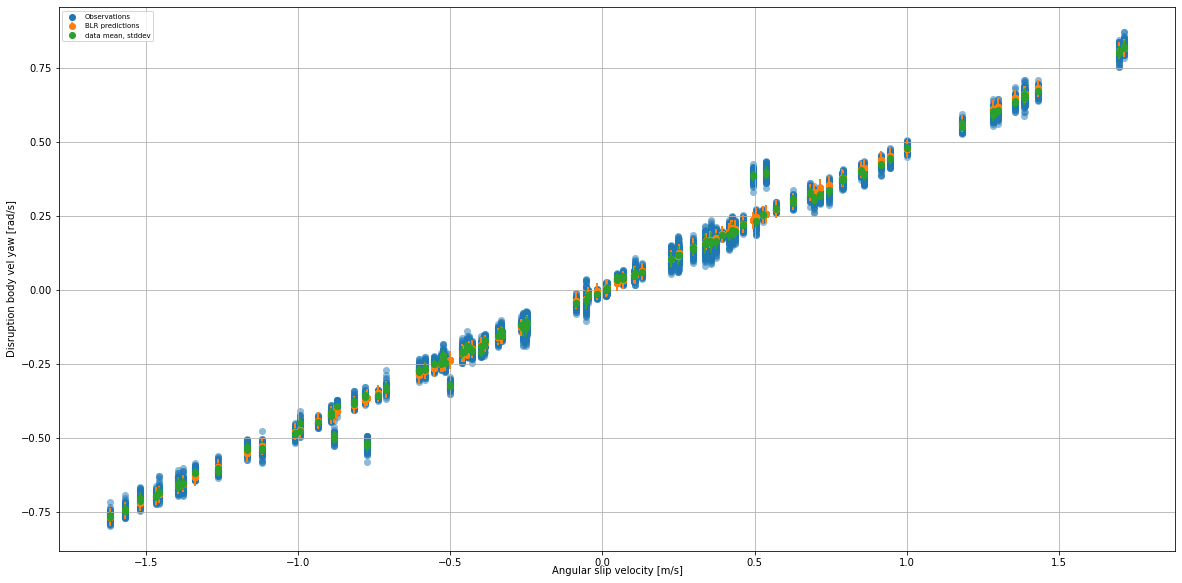

In [327]:
# check yaw gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

# time_vec = np.linspace(0, test_mean_body_vel_disturption_yaw.shape[0], test_mean_body_vel_disturption_yaw.shape[0])

test_ang_slip = ax.scatter(x_test[:, 1], y_test_yaw, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)

blr_yaw_prediction, blr_yaw_std = blr_yaw.predict(x_test, return_std=True)
print(blr_yaw_std)
test_mean_stdev = plt.errorbar(x_test[:, 1], blr_yaw_prediction, blr_yaw_std, c='C1', fmt='o', label='BLR predictions')

test_mean_stdev = plt.errorbar(test_steady_state_idd_body_vel_yaw[:, -1], test_mean_body_vel_disturption_yaw, test_stdev_body_vel_disturption_yaw, c='C2', fmt='o', label='data mean, stddev')

# blr_mean_stdev = plt.errorbar(x_test[:, -1], blr_yaw_prediction, 2*blr_yaw_std, c='C2', fmt='o', label='BLR predictions')

ax.grid()

ax.set_xlabel('Angular slip velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel yaw [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

# ax.set_ylim(-1, 1)

# print(x_test.shape)
# print(blr_yaw_prediction.shape)
# print(blr_yaw_std)
print(test_idd_body_vel_yaw_array.shape)
print(test_mean_body_vel_disturption_yaw.shape)

(8000, 2)
(8000,)


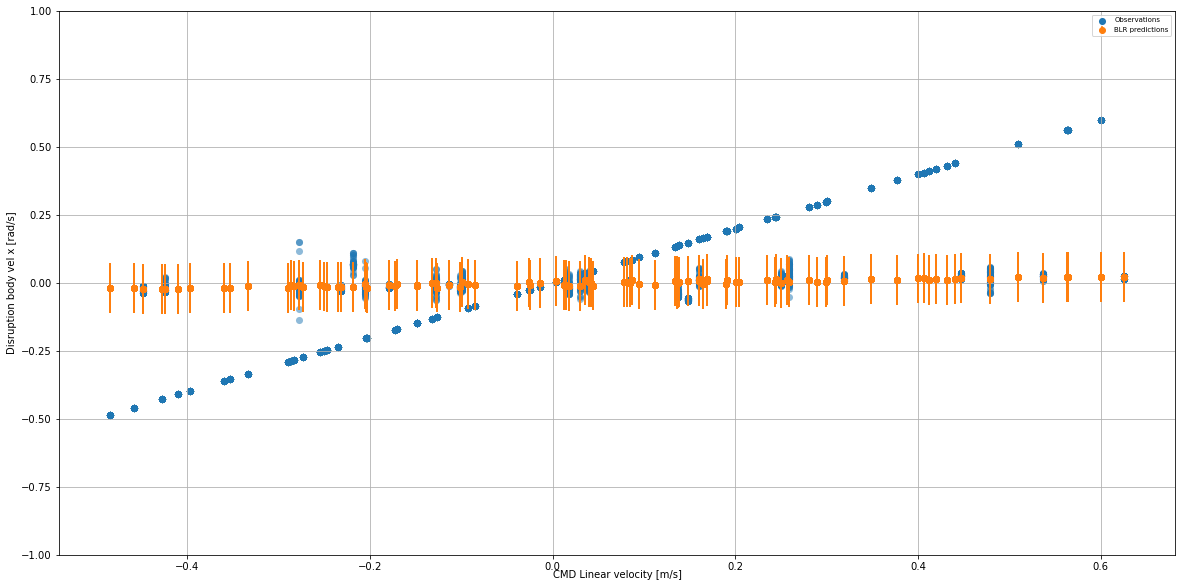

In [328]:
# check x gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

# time_vec = np.linspace(0, test_mean_body_vel_disturption_x.shape[0], test_mean_body_vel_disturption_x.shape[0])

test_ang_slip = ax.scatter(x_test[:, 0], y_test_x, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)

blr_x_prediction, blr_x_std = blr_x.predict(x_test, return_std=True)

plt.errorbar(x_test[:, 0], blr_x_prediction, 3*blr_x_std, c='C1', fmt='o', label='BLR predictions')

ax.set_xlabel('CMD Linear velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel x [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

ax.set_ylim(-1, 1)

ax.grid()

print(x_test.shape)
print(blr_x_prediction.shape)

In [329]:
# get BLR params

params_blr_x = blr_x.get_params()
print('blr_x')
print(params_blr_x)

params_blr_y = blr_y.get_params()
print('blr_y')
print(params_blr_y)

params_blr_yaw = blr_yaw.get_params()
print('blr_yaw')
print(params_blr_yaw)

blr_x
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': 0.1, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': 0.001, 'n_iter': 300, 'tol': 0.001, 'verbose': False}
blr_y
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 300, 'tol': 1e-06, 'verbose': False}
blr_yaw
{'alpha_1': 1e-06, 'alpha_2': 1e-06, 'alpha_init': None, 'compute_score': False, 'copy_X': True, 'fit_intercept': True, 'lambda_1': 1e-06, 'lambda_2': 1e-06, 'lambda_init': None, 'n_iter': 300, 'tol': 1e-06, 'verbose': False}


In [330]:
# Try the same using custom BLR
from models.learning.blr_slip import SlipBayesianLinearRegression

slip_input_dimensions = 2
a_param_init = 0
b_param_init = 0
param_variance_init = 999999999999999999999
variance_init = 1000000000

slip_blr = SlipBayesianLinearRegression(slip_input_dimensions, a_param_init, b_param_init, param_variance_init, variance_init)

slip_blr.train_params(x_train, y_train_angular_slip)

test_blr_slip_ang_mean, test_blr_slip_ang_variance = slip_blr.predict(x_test)

print(slip_blr.weights)
print(slip_blr.params_covariance)
print(slip_blr.a_param_n)
print(slip_blr.b_param_n)

print(test_blr_slip_ang_mean[:, 0].shape)
print(np.sqrt(np.diag(test_blr_slip_ang_variance)))

[[-0.00992775]
 [ 0.47440988]]
[[1.49969612e-03 2.02507697e-05]
 [2.02507697e-05 2.00526620e-04]]
4000.0
[[3.45027255]]
(8000,)
[0.02937716 0.02937716 0.02937716 ... 0.02937879 0.02937879 0.02937879]


(8000, 2)


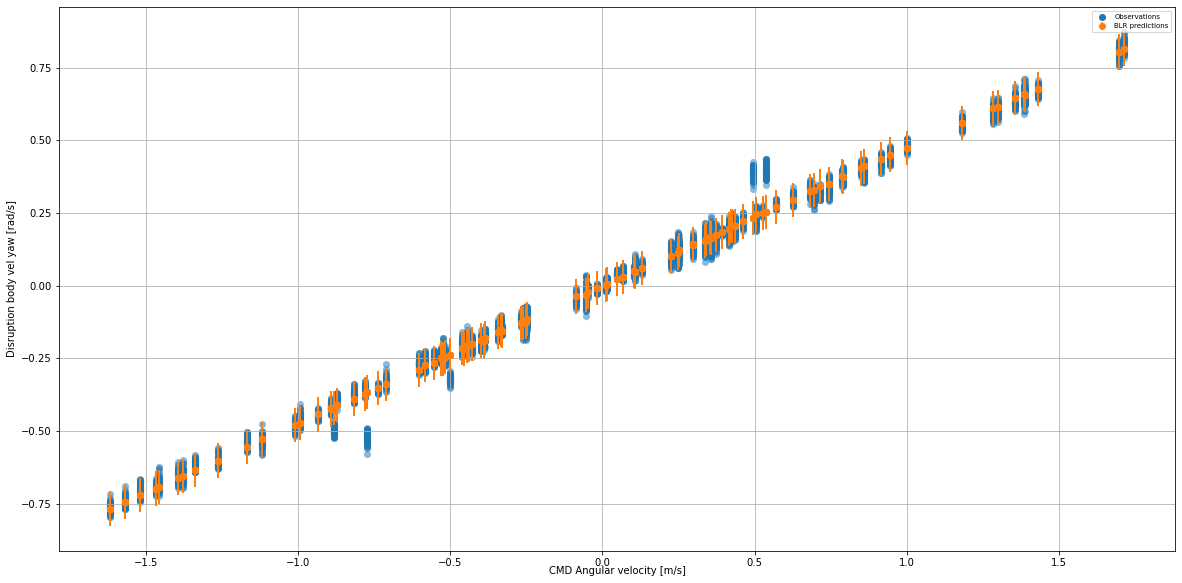

In [331]:
# check x gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

# time_vec = np.linspace(0, test_mean_body_vel_disturption_x.shape[0], test_mean_body_vel_disturption_x.shape[0])

test_ang_slip = ax.scatter(x_test[:, 1], y_test_yaw, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)

blr_x_prediction, blr_x_std = blr_x.predict(x_test, return_std=True)

plt.errorbar(x_test[:, 1], test_blr_slip_ang_mean[:, 0], 2*np.sqrt(np.diag(test_blr_slip_ang_variance)), c='C1', fmt='o', label='BLR predictions')

ax.set_xlabel('CMD Angular velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel yaw [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

# ax.set_ylim(-1, 1)

ax.grid()

print(x_test.shape)

In [332]:
# generate new training input based on Seegmiller params

x_train_x = steady_state_idd_body_vel_x.flatten()
x_train_y = steady_state_idd_body_vel_x.flatten() * steady_state_idd_body_vel_yaw.flatten()
x_train_yaw = np.column_stack((steady_state_idd_body_vel_x.flatten() * steady_state_idd_body_vel_yaw.flatten(), 
                               steady_state_idd_body_vel_x.flatten(), 
                               steady_state_idd_body_vel_yaw.flatten()))

a_param_init = 0
b_param_init = 0
param_variance_init = 999999999999999999999
variance_init = 1000000000

slip_blr_x = SlipBayesianLinearRegression(1, a_param_init, b_param_init, param_variance_init, variance_init)
slip_blr_y = SlipBayesianLinearRegression(1, a_param_init, b_param_init, param_variance_init, variance_init)
slip_blr_yaw = SlipBayesianLinearRegression(3, a_param_init, b_param_init, param_variance_init, variance_init)

slip_blr_x.train_params(x_train_x, y_train_longitudinal_slip)
slip_blr_y.train_params(x_train_y, y_train_lateral_slip)
slip_blr_yaw.train_params(x_train_yaw, y_train_angular_slip)

print(slip_blr_x.weights)
print(slip_blr_y.weights)
print(slip_blr_yaw.weights)

[[0.04203425]]
[[0.05016396]]
[[ 0.02211959]
 [-0.00794044]
 [ 0.47488384]]


In [333]:
x_test_x = test_steady_state_idd_body_vel_x.flatten()
x_test_y = test_steady_state_idd_body_vel_x.flatten() * test_steady_state_idd_body_vel_yaw.flatten()
x_test_yaw = np.column_stack((test_steady_state_idd_body_vel_x.flatten() * test_steady_state_idd_body_vel_yaw.flatten(), 
                               test_steady_state_idd_body_vel_x.flatten(), 
                               test_steady_state_idd_body_vel_yaw.flatten()))

test_blr_slip_x_mean, test_blr_slip_x_variance = slip_blr_x.predict(x_test_x)
test_blr_slip_y_mean, test_blr_slip_y_variance = slip_blr_y.predict(x_test_y)
test_blr_slip_yaw_mean, test_blr_slip_yaw_variance = slip_blr_yaw.predict(x_test_yaw)

(8000, 2)


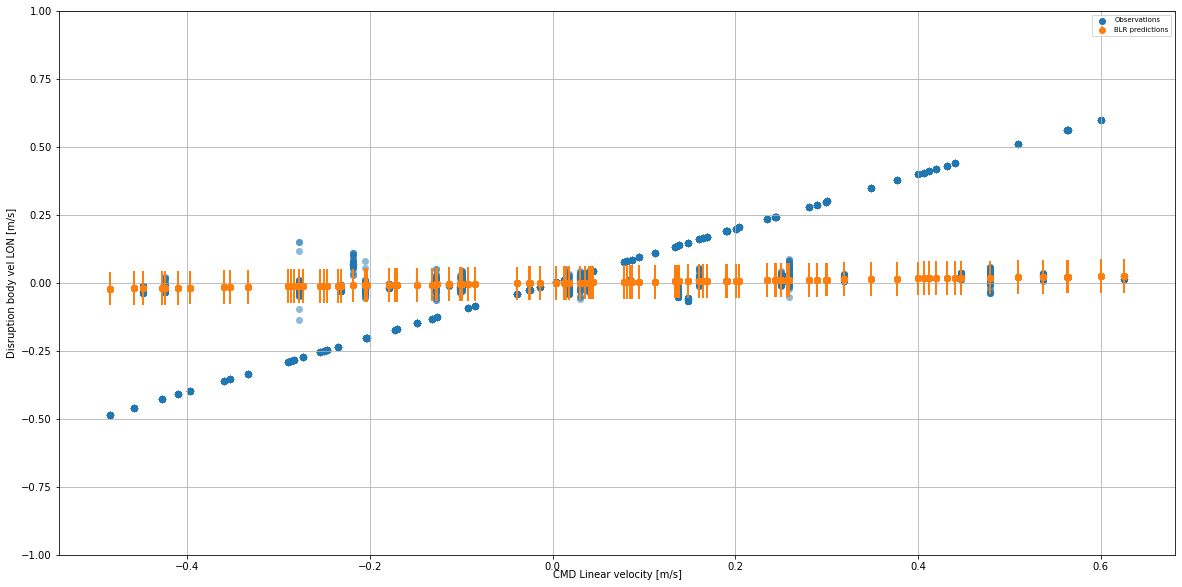

In [334]:
# check x slip BLR fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

# time_vec = np.linspace(0, test_mean_body_vel_disturption_x.shape[0], test_mean_body_vel_disturption_x.shape[0])

test_ang_slip = ax.scatter(x_test_x, y_test_x, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)


plt.errorbar(x_test_x, test_blr_slip_x_mean[:, 0], 2*np.sqrt(np.diag(test_blr_slip_x_variance)), c='C1', fmt='o', label='BLR predictions')

ax.set_xlabel('CMD Linear velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel LON [m/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

ax.set_ylim(-1, 1)

ax.grid()

print(x_test.shape)

(8000, 2)


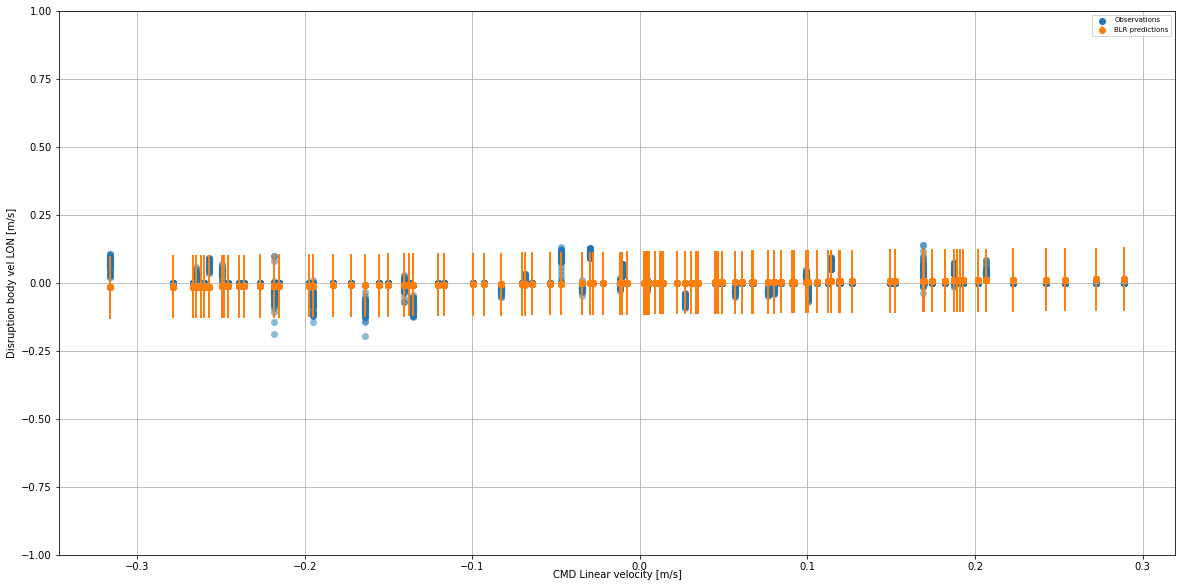

In [335]:
plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

# time_vec = np.linspace(0, test_mean_body_vel_disturption_x.shape[0], test_mean_body_vel_disturption_x.shape[0])

test_ang_slip = ax.scatter(x_test_y, y_test_y, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)


plt.errorbar(x_test_y, test_blr_slip_y_mean[:, 0], 2*np.sqrt(np.diag(test_blr_slip_y_variance)), c='C1', fmt='o', label='BLR predictions')

ax.set_xlabel('CMD Linear velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel LON [m/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

ax.set_ylim(-1, 1)

ax.grid()

print(x_test.shape)

(8000, 2)


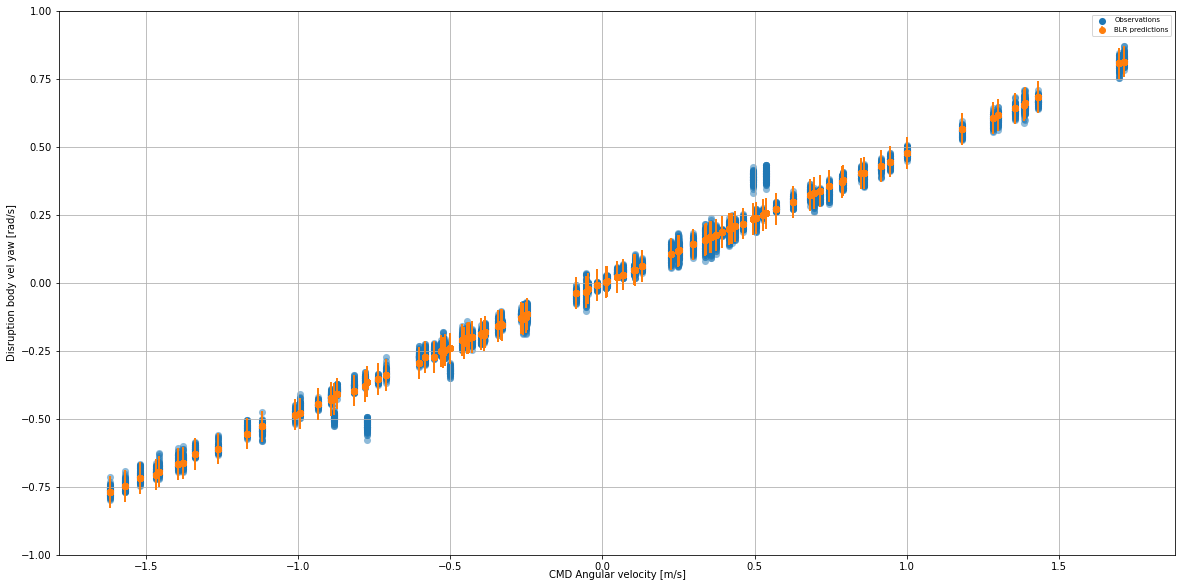

In [336]:
# check x gaussian process fit on test data

plt.figure(figsize=(20,10))
ax = plt.gca()
fig = plt.gcf()

line_width = 5
alpha = 0.2


alpha_plot = 0.5

# time_vec = np.linspace(0, test_mean_body_vel_disturption_x.shape[0], test_mean_body_vel_disturption_x.shape[0])

test_ang_slip = ax.scatter(x_test_yaw[:, 2], y_test_yaw, 
                  c = 'C0',
                  cmap = 'viridis', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Observations',
                 rasterized=True)


plt.errorbar(x_test_yaw[:, 2], test_blr_slip_yaw_mean[:, 0], 2*np.sqrt(np.diag(test_blr_slip_yaw_variance)), c='C1', fmt='o', label='BLR predictions')

ax.set_xlabel('CMD Angular velocity [m/s]', labelpad=-2)
ax.set_ylabel('Disruption body vel yaw [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xlim(-3, 3)

ax.set_ylim(-1, 1)

ax.grid()

print(x_test.shape)

In [337]:
# prepare data to propagate model prediction, uncertainty

icp_x_str_list = []
icp_y_str_list = []
icp_z_str_list = []
icp_roll_str_list = []
icp_pitch_str_list = []
icp_yaw_str_list = []
for i in range(0, 40):
    str_icp_x_i = 'icp_corrected_interpolated_x_' + str(i)
    str_icp_y_i = 'icp_corrected_interpolated_y_' + str(i)
    # str_icp_x_i = 'icp_interpolated_x_' + str(i)
    # str_icp_y_i = 'icp_interpolated_y_' + str(i)
    str_icp_yaw_i = 'icp_interpolated_yaw_' + str(i)
    # str_icp_x_i = 'icp_x_' + str(i)
    # str_icp_y_i = 'icp_y_' + str(i)
    # str_icp_yaw_i = 'icp_yaw_' + str(i)
    icp_x_str_list.append(str_icp_x_i)
    icp_y_str_list.append(str_icp_y_i)
    icp_yaw_str_list.append(str_icp_yaw_i)
icp_x_array = dataset_test[icp_x_str_list].to_numpy()
icp_y_array = dataset_test[icp_y_str_list].to_numpy()
icp_yaw_array = dataset_test[icp_yaw_str_list].to_numpy()


In [378]:
# prepare nominal and ICP trajectories

window_id = 19
# window_id = 303
# window_id = 230
window_size = icp_x_array.shape[1]

# print(dataset_test['init_icp_x'])
print(test_steady_state_mask[window_id])

init_state = np.array([dataset_test['init_icp_x'][window_id], dataset_test['init_icp_y'][window_id], dataset_test['init_icp_yaw'][window_id]])
print(init_state)

icp_states = np.zeros((window_size, 3))
icp_states[0, 0] = dataset_test['init_icp_x'][window_id]
icp_states[0, 1] = dataset_test['init_icp_y'][window_id]
icp_states[0, 2] = dataset_test['init_icp_yaw'][window_id]

idd_states = np.zeros((window_size, 3))
idd_states[0, :] = init_state


for i in range(1, window_size):
    icp_states[i,:] = np.array([icp_x_array[window_id, i], icp_y_array[window_id, i], icp_yaw_array[window_id, i]])
    idd_states[i, 0] = idd_states[i-1, 0] + np.cos(idd_states[i-1, 2]) * test_idd_body_vel_x_array[window_id, i-1] * dt
    idd_states[i, 1] = idd_states[i-1, 1] + np.sin(idd_states[i-1, 2]) * test_idd_body_vel_x_array[window_id, i-1] * dt
    idd_states[i, 2] = idd_states[i-1, 2] + test_idd_body_vel_yaw_array[window_id, i-1] * dt
    
# print(icp_states)

True
[0. 0. 0.]


In [379]:
# compute nominal sigma-point prediction

x_horizon_x = test_idd_body_vel_x_array[window_id, :]
x_horizon_y = test_idd_body_vel_x_array[window_id, :] * test_idd_body_vel_yaw_array[window_id, :]
x_horizon_yaw = np.column_stack((test_idd_body_vel_x_array[window_id, :] * test_idd_body_vel_yaw_array[window_id, :], 
                               test_idd_body_vel_x_array[window_id, :], 
                               test_idd_body_vel_yaw_array[window_id, :]))

horizon_blr_slip_x_mean, horizon_blr_slip_x_variance = slip_blr_x.predict(x_horizon_x)
horizon_blr_slip_y_mean, horizon_blr_slip_y_variance = slip_blr_y.predict(x_horizon_y)
horizon_blr_slip_yaw_mean, horizon_blr_slip_yaw_variance = slip_blr_yaw.predict(x_horizon_yaw)

# print(horizon_blr_slip_x_mean)
# print(np.diag(horizon_blr_slip_x_variance))

initial_state_covariance = np.zeros((3))

blr_slip_states = np.zeros((window_size, 3))
# blr_slip_states[0, :] = init_state

blr_body_to_world_rotmat = np.eye(2)

for i in range(1, window_size):
    blr_body_vel = np.array([test_idd_body_vel_x_array[window_id, i-1] - horizon_blr_slip_x_mean[i-1], test_idd_body_vel_y_array[window_id, i-1] - horizon_blr_slip_y_mean[i-1]]).reshape(2,1)
    # print(blr_body_vel)
    yaw_to_rotmat2d(blr_body_to_world_rotmat, blr_slip_states[i-1, 2])
    blr_world_vel = blr_body_to_world_rotmat @ blr_body_vel
    
    blr_slip_states[i, 0] = blr_slip_states[i-1, 0] + blr_world_vel[0] * dt
    blr_slip_states[i, 1] = blr_slip_states[i-1, 1] + blr_world_vel[1] * dt
    blr_slip_states[i, 2] = blr_slip_states[i-1, 2] + (test_idd_body_vel_yaw_array[window_id, i-1] - horizon_blr_slip_yaw_mean[i-1]) * dt


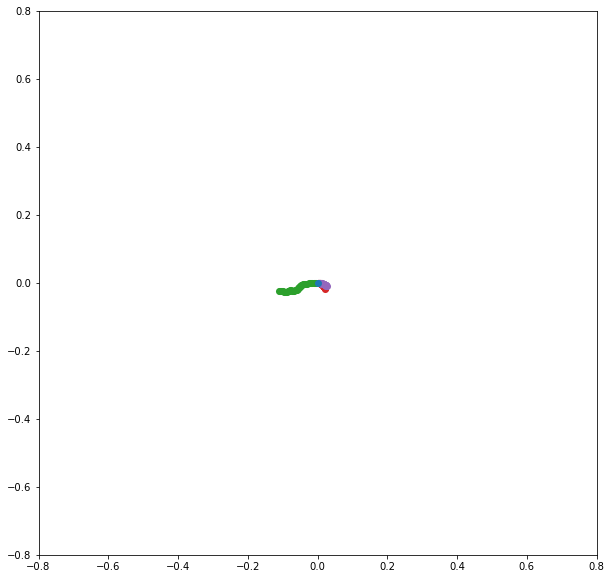

In [380]:
# plot uncertainty propagation

plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

ax.set_xlim(-0.8, 0.8)
ax.set_ylim(-0.8, 0.8)

alpha_plot = 1.0



prediction_idd = ax.scatter(idd_states[1:, 0], idd_states[1:, 1], 
                  c = 'C3', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

prediction_blr = ax.scatter(blr_slip_states[1:, 0], blr_slip_states[1:, 1], 
                  c = 'C4', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

int_states = ax.scatter(icp_states[1:, 0], icp_states[1:, 1], 
                  c = 'C2', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='end_state',
                 rasterized=True)

init_state = ax.scatter(dataset_test['init_icp_x'][window_id], dataset_test['init_icp_y'][window_id], 
                  c = 'C0', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='init_state',
                 rasterized=True)

# end_state = ax.scatter(dataset_test['gt_icp_x'][window_id], dataset_test['gt_icp_y'][window_id], 
#                   c = 'C1', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='end_state',
#                  rasterized=True)





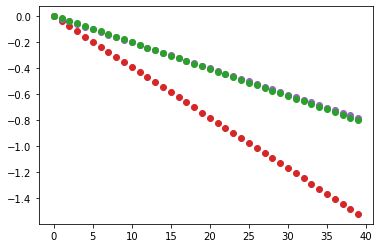

In [356]:
plt.plot(idd_states[:, 2], 'o', c='C3')
plt.plot(blr_slip_states[:, 2], 'o', c='C4')
plt.plot(icp_states[:, 2], 'o', c='C2')

